<a href="https://colab.research.google.com/github/hsiuchun/NLP/blob/main/Semantic_Analysis_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 情緒分析

資料集: [Learning Word Vectors for Sentiment Analysis](https://aclanthology.org/P11-1015.pdf)

程式碼參考自: [huggingface](https://huggingface.co/)

> **資料集說明**

Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

>**本次介紹模型為BERT**

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://github.com/google-research/bert)

程式碼參考自: [huggingface](https://huggingface.co/)

![](https://i.imgur.com/spiKPbQ.png)

[可搭配李宏毅大大的說明影片食用](https://youtu.be/UYPa347-DdE)

**訓練一個BERT分類模型，輸入是一句話，辨識出這句話的情緒傾向。**

## 定義你的 Hyperparameters

* 如果電腦的記憶體不夠可以試著減少 batch_size
* 因為我們採用現有的模型去fine-tune，所以一般不需要設太多 epochs
* config 就是我們所使用的現有模型，可以自己找適合的做替換
* 這次是做二分類所以 num_class 是 2
* 如果你的模型 overfit 了，可以把 dropout 調高
* 可以試著調高或調低 learning_rate，這會影響他的學習速度（跨步的大小）
* 你應該先檢閱你的資料再來決定 max_len （但 BERT 最大只吃到 512）

In [1]:
from datetime import datetime
parameters = {
    "num_class": 8,
    "time": str(datetime.now()).replace(" ", "_"),
    "seed": 1111,
    # Hyperparameters
    "model_name": 'BERT',
    "config": 'bert-base-uncased',
    "learning_rate": 2e-4,
    "epochs": 1,
    "max_len": 512,
    "batch_size": 16,
    "dropout": 0.1,
    "activation": 'Prelu',
    "hidden_dim": 384,
}

## 資料集準備

- 資料集說明 :
  - text: a string feature.
  - label: a classification label, with possible values including neg (0), pos (1).

### 載入資料

安裝 huggingface 的 dataset 套件（可以直接透過 pip 安裝是不是很方便）

看一下資料格式長怎樣

結合 huggingface 上 imdb 的介紹 及圖 2，我們可以發現 unsupervised 的資料是沒有正負向標籤的，因此本次只採用 train 與 test 資料。

在這步驟，我們需要將原資料重新進行分割。將 train 與 test 資料合併後切割成 3:1:1 或是 8:1:1 的一組新的 train/val/test 資料集。

把資料拿出來後，將train及test合併，重新切割後，儲存下來。


---


作者於此處將資料合併重切，是為了得到驗證集和增加訓練筆數。當然也可以直接從測試集直接 sample 驗證集，每個人的作法不一定相同～但若要與其他模型比較，需採用一致的測試集。

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")
torch.cuda.is_available()

import pandas as pd
folder_name = 'dm-2024-isa-5810-lab-2-homework'
data_identification = pd.read_csv(folder_name + '/data_identification.csv')
emotion = pd.read_csv(folder_name + '/emotion.csv')
sample_submission = pd.read_csv(folder_name + '/sampleSubmission.csv')

print(data_identification)
print(data_identification.shape)
print(f"{'='*40}")
print(emotion)
print(emotion.shape)
print(f"{'='*40}")
print(sample_submission)
print(f"{'='*40}")

df_twitter = pd.read_json(folder_name + '/tweets_DM.json', lines=True)
train_ids = data_identification[data_identification['identification'] == 'train']['tweet_id'].tolist()
test_ids = data_identification[data_identification['identification'] == 'test']['tweet_id'].tolist()

print("Show ids of train and test\n")
print(len(train_ids))
print(len(test_ids))
print(len(train_ids) + len(test_ids))

df_twitter_expanded = pd.json_normalize(df_twitter['_source'])

print("After expand the tweet_id, tweet_hashtag...\n")
df_twitter['tweet_id'] = df_twitter_expanded['tweet.tweet_id']
df_twitter['text'] = df_twitter_expanded['tweet.text']
df_twitter['hash_tags'] = df_twitter_expanded['tweet.hashtags']

df_twitter_train = df_twitter[df_twitter['tweet_id'].isin(train_ids)]
df_twitter_test = df_twitter[df_twitter['tweet_id'].isin(test_ids)]

print("After saperate train and test:\n")
print(df_twitter_train.shape)
print(df_twitter_test.shape)

df_twitter_train = pd.merge(df_twitter_train, emotion, on='tweet_id', how='left')

         tweet_id identification
0        0x28cc61           test
1        0x29e452          train
2        0x2b3819          train
3        0x2db41f           test
4        0x2a2acc          train
...           ...            ...
1867530  0x227e25          train
1867531  0x293813          train
1867532  0x1e1a7e          train
1867533  0x2156a5          train
1867534  0x2bb9d2          train

[1867535 rows x 2 columns]
(1867535, 2)
         tweet_id       emotion
0        0x3140b1       sadness
1        0x368b73       disgust
2        0x296183  anticipation
3        0x2bd6e1           joy
4        0x2ee1dd  anticipation
...           ...           ...
1455558  0x38dba0           joy
1455559  0x300ea2           joy
1455560  0x360b99          fear
1455561  0x22eecf           joy
1455562  0x2fb282  anticipation

[1455563 rows x 2 columns]
(1455563, 2)
              id   emotion
0       0x2c7743  surprise
1       0x2c1eed  surprise
2       0x2826ea  surprise
3       0x356d9a  surprise
4  

### [Tokenizer 簡介](https://huggingface.co/docs/transformers/main_classes/tokenizer)

這邊會先帶大家快速走一遍 Tokenzier 是怎麼做的

In [3]:
from transformers import AutoTokenizer

In [4]:
config_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(config_name)

In [5]:
sample_s = "How's everything going?"
token = tokenizer.tokenize(sample_s)
print(token)

['how', "'", 's', 'everything', 'going', '?']


In [6]:
sample_s = "How's everything going?"
ids = tokenizer.encode(sample_s)
print(ids)

[101, 2129, 1005, 1055, 2673, 2183, 1029, 102]


In [7]:
tokenizer.decode(ids)

"[CLS] how ' s everything going? [SEP]"

In [8]:
print(tokenizer.convert_ids_to_tokens(ids))
print(tokenizer.convert_tokens_to_ids(token))
print(tokenizer.convert_tokens_to_string(token))

['[CLS]', 'how', "'", 's', 'everything', 'going', '?', '[SEP]']
[2129, 1005, 1055, 2673, 2183, 1029]
how ' s everything going?


In [9]:
sample_s = "How's everything going?"
es = tokenizer.encode_plus(sample_s)
print(es)

{'input_ids': [101, 2129, 1005, 1055, 2673, 2183, 1029, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [10]:
inputs = tokenizer.encode_plus(
    sample_s,
    max_length = 7,
    truncation = True,
    padding = 'max_length',
    return_tensors = 'pt'
)
print(inputs)

{'input_ids': tensor([[ 101, 2129, 1005, 1055, 2673, 2183,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [11]:
sample_os = "How are you?"
os = tokenizer.encode_plus(
    sample_os,
    max_length = 7,
    truncation = True,
    padding = 'max_length'
)
print(os)

{'input_ids': [101, 2129, 2024, 2017, 1029, 102, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 0]}


### 自定義 Dataset，將tokenzie的步驟放進去

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch
import torch.nn.functional as Fun

# Using Dataset to build DataLoader
class CustomDataset(Dataset):
    def __init__(self, mode, df, specify, args):
        assert mode in ["train", "val", "test"]  # 一般會切三份
        self.mode = mode
        self.df = df
        self.specify = specify # specify column of data (the column U use for predict)
        if self.mode != 'test':
          self.label = df['label']
        self.tokenizer = AutoTokenizer.from_pretrained(args["config"])
        self.max_len = args["max_len"]
        self.num_class = args["num_class"]

    def __len__(self):
        return len(self.df)

    # transform label to one_hot label (if num_class > 2)
    def one_hot_label(self, label):
        return Fun.one_hot(torch.tensor(label, dtype=torch.long), num_classes=self.num_class)

    # transform text to its number
    def tokenize(self,input_text):
        inputs = self.tokenizer.encode_plus(
            input_text,
            max_length = self.max_len,
            truncation = True,
            padding = 'max_length'
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return ids,mask,token_type_ids

    # get single data
    def __getitem__(self, index):

        sentence = str(self.df[self.specify][index])
        ids, mask, token_type_ids = self.tokenize(sentence)


        if self.mode == "test":
            return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
                torch.tensor(token_type_ids, dtype=torch.long)
        else:
            return torch.tensor(ids, dtype=torch.long), torch.tensor(mask, dtype=torch.long), \
                torch.tensor(token_type_ids, dtype=torch.long), torch.tensor(self.label.iloc[index], dtype=torch.long)

### 建立 DataLoader

讀入資料並傳入自定的 Dataset 以自訂資料格式

之後傳入DataLoader以利後續訓練進行（將資料批次化以免記憶體爆掉）

In [13]:
from sklearn.preprocessing import LabelEncoder

emotion_label = df_twitter_train['emotion']
label_encoder = LabelEncoder()
label_encoder.fit(emotion_label)
print('check label: ', label_encoder.classes_)

emotion_label = label_encoder.fit_transform(df_twitter_train['emotion'])

# 檢查轉換結果
print("Encoded Labels:", emotion_label[:4])
print("Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

df_twitter_train['label'] = emotion_label
df_twitter_train.head()

check label:  ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']
Encoded Labels: [1 5 3 4]
Mapping: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


,_score,_index,_source,_crawldate,_type,tweet_id,text,hash_tags,emotion,label
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets,0x376b20,"People who post ""add me on #Snapchat"" must be ...",[Snapchat],anticipation,1
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...","[freepress, TrumpLegacy, CNN]",sadness,5
2,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,[],fear,3
3,120,hashtag_tweets,"{'tweet': {'hashtags': ['authentic', 'LaughOut...",2015-06-11 04:44:05,tweets,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,"[authentic, LaughOutLoud]",joy,4
4,1021,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2c91...",2015-08-18 02:30:07,tweets,0x2c91a8,Still waiting on those supplies Liscus. <LH>,[],anticipation,1


In [14]:
train_df, val_df = train_test_split(df_twitter_train, random_state=1111, train_size=0.8)

In [15]:
train_df = pd.DataFrame({
    "text": train_df['text'],
    "label": train_df['label']
})

val_df = pd.DataFrame({
    "text": val_df['text'],
    "label": val_df['label']
})

In [16]:
print(train_df.shape)
print(val_df.shape)

(1164450, 2)
(291113, 2)


In [17]:
import transformers
import pandas as pd

# load training data
train_df = train_df.reset_index(drop=True)
train_dataset = CustomDataset('train', train_df, 'text', parameters)
train_loader = DataLoader(train_dataset, batch_size=parameters['batch_size'], shuffle=True)

# load validation data
val_df = val_df.reset_index(drop=True)
val_dataset = CustomDataset('val', val_df, 'text', parameters)
val_loader = DataLoader(val_dataset, batch_size=parameters['batch_size'], shuffle=True)

In [18]:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

## 建立模型

*   自己重新寫分類模型
*   模型訓練與評估的程式碼大致上相同，差別在於模型是否繼續進行梯度下降，以及模型參數是否繼續訓練



### train utils

In [19]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# get predict result
def get_pred(logits):
    return torch.argmax(logits, dim=1)

# calculate confusion metrics
def cal_metrics(pred, ans, method):
    '''
    Parameter
    ---------
    pred: [list], predict class
    ans: [list], true class
    method: 'micro', 'weighted', 'macro'.
    ---------
    '''
    if pred.get_device() != 'cpu':
        pred = pred.detach().cpu().numpy()
    if ans.get_device() != 'cpu':
        ans = ans.detach().cpu().numpy()
    rec = recall_score(pred, ans, average=method, zero_division=0)
    f1 = f1_score(pred, ans, average=method, zero_division=0)
    prec = precision_score(pred, ans, average=method, zero_division=0)
    acc = accuracy_score(pred, ans)
    return acc, f1, rec, prec

In [20]:
# save model to path
def save_checkpoint(save_path, model):
    if save_path == None:
        return
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to ==> {save_path}')

# load model from path
def load_checkpoint(load_path, model, device):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict)
    return model

In [21]:
import matplotlib.pyplot as plt

# draw the learning curve
def draw_pic(record, name, img_save=False, show=False):
    x_ticks = range(1, parameters["epochs"]+1)

    plt.figure(figsize=(6, 3))

    plt.plot(x_ticks, record['train_'+name], '-o', color='lightskyblue',
             markeredgecolor="teal", markersize=3, markeredgewidth=1, label = 'Train')
    plt.plot(x_ticks, record['val_'+name], '-o', color='pink',
             markeredgecolor="salmon", markersize=3, markeredgewidth=1, label = 'Val')
    plt.grid(color='lightgray', linestyle='--', linewidth=1)

    plt.title('Model', fontsize=14)
    plt.ylabel(name, fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right' if not name.lower().endswith('loss') else 'upper right')

    if img_save:
        plt.savefig(name+'.png', transparent=False, dpi=300)
    if show:
        plt.show()

    plt.close()

In [22]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.base import MIMEBase
from email import encoders

def send_email(hyperparameters, png_files):

    # create MIMEMultipart
    msg = MIMEMultipart()

    # define sender and receiver, U need to change this for yours
    msg['From'] = 'YOUR EMAIL ACCOUNT'
    msg['To'] = 'YOUR EMAIL ACCOUNT'

    msg['Subject'] = 'Training Result'

    # create text content
    text = MIMEText(f'{hyperparameters}\n\n')
    msg.attach(text)

    # read png
    for file in png_files:
        with open(file, 'rb') as fp:
            image = MIMEBase('application', "octet-stream")
            image.set_payload(fp.read())
        encoders.encode_base64(image)
        image.add_header('Content-Disposition', 'attachment', filename=file)
        msg.attach(image)

    # 建立 SMTP 服務
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.ehlo()
    server.starttls()
    server.login('YOUR EMAIL ACCOUNT',  'YOUR EMAIL PASSWOED') # U need to change this for yours

    server.send_message(msg)  # send email
    server.quit()  # close the email channel

### model

In [23]:
import torch.nn as nn

# define different activation function
def get_activation(activation):
    if activation == 'Prelu':
        return nn.PReLU()
    elif activation == 'relu':
        return nn.ReLU()
    elif activation == 'sigmoid':
        return nn.Sigmoid()
    elif activation == 'gelu':
        return nn.GELU()
    elif activation == 'LeakyReLU':
        return nn.LeakyReLU()
    else:
        return nn.Tanh()

# Dense Layer
# It is composed of linear, (dropout), and activation layers.
# dropout is optional, and activation is needed when there is more than one linear layer
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate, activation='tanh'):
        super(Dense, self).__init__()

        self.hidden_layer = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = get_activation(activation) # default tanh
        nn.init.xavier_uniform_(self.hidden_layer.weight) # you also can change the initialize method

    def forward(self, inputs):
        logits = self.hidden_layer(inputs)
        logits = self.dropout(logits)
        logits = self.activation(logits)

        return logits

In [24]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertModel
import torch.nn as nn

# BERT Model
class BertClassifier(BertPreTrainedModel):
    def __init__(self, config, args):
        super(BertClassifier, self).__init__(config)
        self.bert = BertModel(config)
        self.num_labels = args["num_class"]
        self.dropout = nn.Dropout(args["dropout"])
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        self.init_weights()

    # forward function, data in model will do this
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None,
                head_mask=None, inputs_embeds=None, labels=None, output_attentions=None,
                output_hidden_states=None, return_dict=None):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # bert output
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )
        '''
        outputs.keys() -> odict_keys(['last_hidden_state', 'pooler_output'])
        outs.last_hidden_state.shape -> torch.Size([batch_size, 512, 768])
        outs.pooler_output.shape -> torch.Size([batch_size, 768])
        '''

        # get its [CLS] logits
        pooled_output = outputs[1] # (batch_size, 768)
        # add dense layer
        pooled_output = self.dropout(pooled_output) # (batch_size, 768)
        # add linear classifier
        logits = self.classifier(pooled_output) # (batch_size, 2)

        return logits

In [25]:
# evaluate dataloader
def evaluate(model, data_loader, device):
    val_loss, val_acc, val_f1, val_rec, val_prec = 0.0, 0.0, 0.0, 0.0, 0.0
    step_count = 0
    loss_fct = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            ids, masks, token_type_ids, labels = [t.to(device) for t in data]

            logits = model(input_ids = ids,
                    token_type_ids = token_type_ids,
                    attention_mask = masks)
            acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
            loss = loss_fct(logits, labels)

            val_loss += loss.item()
            val_acc += acc
            val_f1 += f1
            val_rec += rec
            val_prec += prec
            step_count+=1

        val_loss = val_loss / step_count
        val_acc = val_acc / step_count
        val_f1 = val_f1 / step_count
        val_rec = val_rec / step_count
        val_prec = val_prec / step_count

    return val_loss, val_acc, val_f1, val_rec, val_prec

In [26]:
# Start training
import time

def train(model, train_loader, val_loader, optimizer, args, device):
  metrics = ['loss', 'acc', 'f1', 'rec', 'prec']
  mode = ['train_', 'val_']
  record = {s+m :[] for s in mode for m in metrics}

  for epoch in range(args["epochs"]):

      st_time = time.time()
      train_loss, train_acc, train_f1, train_rec, train_prec = 0.0, 0.0, 0.0, 0.0, 0.0
      step_count = 0

      model.train()
      for data in train_loader:

          ids, masks, token_type_ids, labels = [t.to(device) for t in data]

          optimizer.zero_grad()

          logits = model(input_ids = ids,
                  token_type_ids = token_type_ids,
                  attention_mask = masks)
          acc, f1, rec, prec = cal_metrics(get_pred(logits), labels, 'macro')
          loss = loss_fct(logits, labels)

          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          train_acc += acc
          train_f1 += f1
          train_rec += rec
          train_prec += prec
          step_count += 1

      # evaluate the model performace on val data after finishing an epoch training
      val_loss, val_acc, val_f1, val_rec, val_prec = evaluate(model, val_loader, device)

      train_loss = train_loss / step_count
      train_acc = train_acc / step_count
      train_f1 = train_f1 / step_count
      train_rec = train_rec / step_count
      train_prec = train_prec / step_count

      print('[epoch %d] cost time: %.4f s'%(epoch + 1, time.time() - st_time))
      print('         loss     acc     f1      rec    prec')
      print('train | %.4f, %.4f, %.4f, %.4f, %.4f'%(train_loss, train_acc, train_f1, train_rec, train_prec))
      print('val  | %.4f, %.4f, %.4f, %.4f, %.4f\n'%(val_loss, val_acc, val_f1, val_rec, val_prec))

      # record training metrics of each training epoch
      record['train_loss'].append(train_loss)
      record['train_acc'].append(train_acc)
      record['train_f1'].append(train_f1)
      record['train_rec'].append(train_rec)
      record['train_prec'].append(train_prec)

      record['val_loss'].append(val_loss)
      record['val_acc'].append(val_acc)
      record['val_f1'].append(val_f1)
      record['val_rec'].append(val_rec)
      record['val_prec'].append(val_prec)

  # save model
  save_checkpoint(args["model_name"] + '_' + args["time"].split('_')[0] + '.pt', model)
  return record

## 開始訓練

### 初始化模型
*   載入模型（這邊會使用已經訓練過的模型，Fine-tune我們的資料集）
*   定義Optimization
  *   通常用Adam就可以了，你也可以換SGD之類的試看看
  *   可以自己看需不需要加scheduler（可以自己寫一個function，也可以直接套用現有的function）
  
  ［請記得pytorch中是以step去計算，想要用epoch去訂定需自行換算］




In [27]:
torch.cuda.is_available()

True

In [28]:
transformers.logging.set_verbosity_error() # close the warning message

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier.from_pretrained(parameters['config'], parameters).to(device)
loss_fct = torch.nn.CrossEntropyLoss() # we use cross entrophy loss

## You can custom your optimizer (e.g. SGD .etc) ##
# we use Adam here
optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], betas=(0.9, 0.999), eps=1e-9)

## You also can add your custom scheduler ##
# num_train_steps = len(train_loader) * parameters['epochs]
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * num_train_steps), num_training_steps=num_train_steps, num_cycles=1)

訓練+畫圖

[epoch 1] cost time: 50966.9371 s
         loss     acc     f1      rec    prec
train | 1.7926, 0.3543, 0.0915, 0.0638, 0.1757
val  | 1.7939, 0.3547, 0.0916, 0.0638, 0.1757

Model saved to ==> BERT_2024-11-17.pt


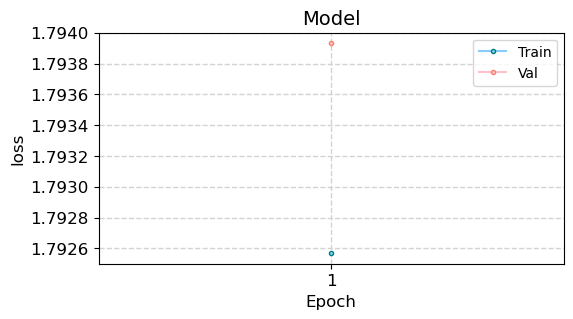

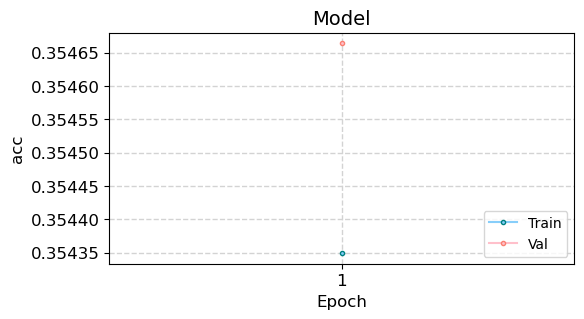

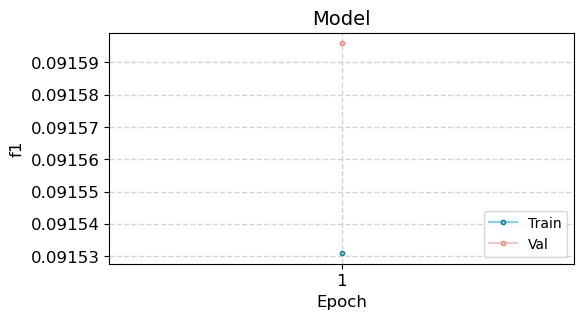

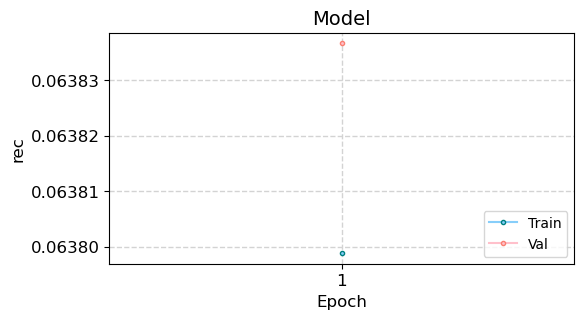

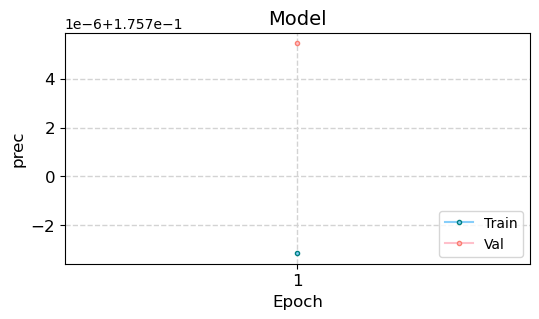

In [29]:
history = train(model, train_loader, val_loader, optimizer, parameters, device)

# draw all metrics figure
draw_pic(history, 'loss', img_save=True, show=True)
draw_pic(history, 'acc', img_save=True, show=True)
draw_pic(history, 'f1', img_save=True, show=True)
draw_pic(history, 'rec', img_save=True, show=True)
draw_pic(history, 'prec', img_save=True, show=True)

files = []
files.append('loss.png')
files.append('acc.png')
files.append('f1.png')
files.append('rec.png')
files.append('prec.png')

## 預測結果

預測單筆（跟評估的程式大同小異）

（你也可以像evaluate function一樣，把它寫成dataloader的形式）



In [39]:
def Softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [40]:
# label to class
def label2class(label):
  l2c = {0:'negative', 1:'positive'}
  return l2c[label]

# predict single sentence
def predict_one(query, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()
  with torch.no_grad():
    inputs = tokenizer.encode_plus(
        query,
        max_length = parameters['max_len'],
        truncation = True,
        padding = 'max_length',
        return_tensors = 'pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)

    # forward pass
    logits = model(input_ids, attention_mask, token_type_ids)
    probs = Softmax(logits) # get each class-probs
    label_index = torch.argmax(probs[0], dim=0)
    pred = label_index.item()

  return probs, pred


In [41]:
# you can load model from existing result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
init_model = BertClassifier.from_pretrained(parameters['config'], parameters) # build an initial model
model = load_checkpoint('./BERT_2024-11-17.pt', init_model, device).to(device) # and load the weight of model from specify file

Model loaded from <== ./BERT_2024-11-17.pt


In [42]:
%%time
probs, pred = predict_one("This movie doesn't attract me", model)
print(probs, pred)
# print(label2class(pred))

tensor([[0.0216, 0.1910, 0.0814, 0.0380, 0.3681, 0.1432, 0.0325, 0.1242]],
       device='cuda:0') 4
CPU times: total: 15.6 ms
Wall time: 327 ms


In [43]:
# predict dataloader
def predict(data_loader, model):

  tokenizer = AutoTokenizer.from_pretrained(parameters['config'])
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  total_probs, total_pred = [], []
  model.eval()
  with torch.no_grad():
    for data in data_loader:
      input_ids, attention_mask, \
      token_type_ids = [t.to(device) for t in data]

      # forward pass
      logits = model(input_ids, attention_mask, token_type_ids)
      probs = Softmax(logits) # get each class-probs
      label_index = torch.argmax(probs[0], dim=0)
      pred = label_index.item()

      total_probs.append(probs)
      total_pred.append(pred)

  return total_probs, total_pred

In [44]:
test_df = pd.DataFrame({
    "text": df_twitter_test['text']
}).reset_index(drop=True)

In [45]:
test_df.head()

,text
0,"Confident of your obedience, I write to you, k..."
1,"""Trust is not the same as faith. A friend is s..."
2,When do you have enough ? When are you satisfi...
3,"God woke you up, now chase the day #GodsPlan #..."
4,"In these tough times, who do YOU turn to as yo..."


In [46]:
# load testing data
test_dataset = CustomDataset('test', test_df, 'text', parameters)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

total_probs, total_pred = predict(test_loader, model)
res = pd.DataFrame({
    "id": test_ids,
    "emotion": total_pred
})

# save result
res.to_csv('./result.csv')

In [48]:
total_pred[:10]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [49]:
total_pred = label_encoder.inverse_transform(total_pred)
total_pred[:10]

array(['joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy', 'joy',
       'joy'], dtype=object)

In [50]:
res = pd.DataFrame({
    "id": test_ids,
    "emotion": total_pred
})

# save result
res.to_csv('./result.csv')

In [47]:
res.head(5)

,id,emotion
0,0x28cc61,4
1,0x2db41f,4
2,0x2466f6,4
3,0x23f9e9,4
4,0x1fb4e1,4
